In [1]:
# Cell 1 — Install & import

!pip install -q scikit-learn pandas joblib gcsfs tqdm
import pandas as pd, joblib, gzip, shutil, pathlib, os, datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample

In [1]:
import sklearn
print(sklearn.__version__)

1.7.0


In [2]:
# Cell 2 — Load the data from GCS

DATA_URI = "gs://steam-reviews-bucket-0/steam_reviews_cleaned.csv"

df = pd.read_csv(DATA_URI)                 # expects 'review_text' & 'review_score'
print("Original class balance:")
display(df['review_score'].value_counts(normalize=True).rename("proportion"))

Original class balance:


review_score
1    0.823246
0    0.176754
Name: proportion, dtype: float64

In [3]:
# Separate classes
pos = df[df.review_score == 1]
neg = df[df.review_score == 0]

# Down-sample positives to match negatives
target_n = len(neg)
pos_down = resample(pos,
                    replace=False,
                    n_samples=target_n,
                    random_state=42)

train_df = pd.concat([pos_down, neg]).sample(frac=1, random_state=42)  # shuffle

print("Balanced training set class counts:")
display(train_df['review_score'].value_counts())

# Train / validation split (20 % val), stratified on *balanced* data
X_train, X_val, y_train, y_val = train_test_split(
    train_df["review_text"],
    train_df["review_score"],
    test_size=0.2,
    random_state=42,
    stratify=train_df["review_score"],
)

print(f"Train: {len(X_train)}   Val: {len(X_val)}")

Balanced training set class counts:


review_score
1    1100596
0    1100596
Name: count, dtype: int64

Train: 1760953   Val: 440239


In [4]:
pipe = make_pipeline(
    TfidfVectorizer(lowercase=True,
                    stop_words="english",
                    max_features=40_000,
                    ngram_range=(1, 2)),
    LogisticRegression(max_iter=1000,
                       n_jobs=-1,
                       solver="lbfgs",
                       class_weight="balanced")   # still helpful
)

pipe.fit(X_train, y_train)

,steps,"[('tfidfvectorizer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [5]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = pipe.predict(X_val)

acc = accuracy_score(y_val, y_pred)
print("Validation accuracy:", round(acc, 4))          # or: print(f"Validation accuracy: {acc:.4f}")

print(classification_report(y_val, y_pred, digits=3))

Validation accuracy: 0.814
              precision    recall  f1-score   support

           0      0.775     0.886     0.826    220120
           1      0.866     0.742     0.800    220119

    accuracy                          0.814    440239
   macro avg      0.821     0.814     0.813    440239
weighted avg      0.821     0.814     0.813    440239



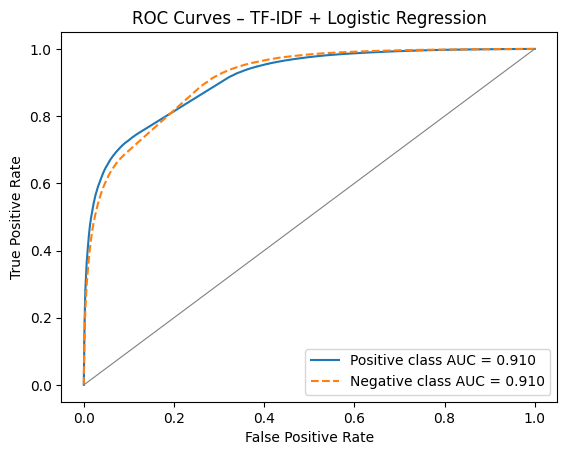

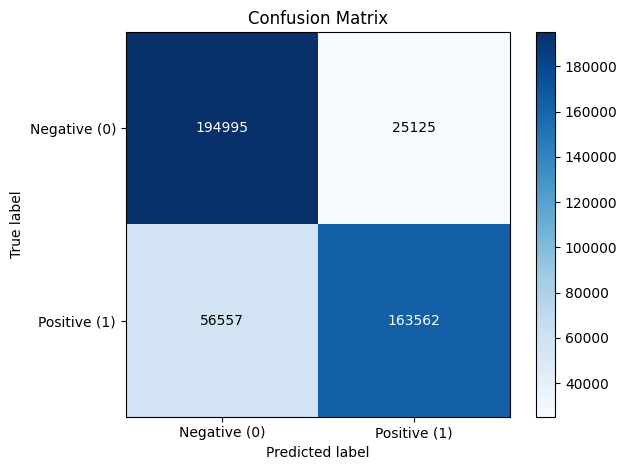

,precision,recall,f1-score,support
Negative (0),0.775,0.886,0.827,220120.000
Positive (1),0.867,0.743,0.800,220119.000
accuracy,0.814,0.814,0.814,0.814
macro avg,0.821,0.814,0.814,440239.000
weighted avg,0.821,0.814,0.814,440239.000


In [5]:
# ==== Evaluation with per-class AUCs ========================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
)

# Probabilities for each class
probs = pipe.predict_proba(X_val)          # [:,0] = P(negative), [:,1] = P(positive)
y_prob_pos = probs[:, 1]
y_prob_neg = probs[:, 0]

# AUC treating class 1 as positive (standard)
auc_pos = roc_auc_score(y_val, y_prob_pos)

# AUC treating class 0 as "positive" (invert labels)
auc_neg = roc_auc_score(1 - y_val, y_prob_neg)

# ROC curve points
fpr_pos, tpr_pos, _ = roc_curve(y_val, y_prob_pos)
fpr_neg, tpr_neg, _ = roc_curve(1 - y_val, y_prob_neg)

# Predictions, confusion matrix, precision/recall table
y_pred = pipe.predict(X_val)
cm = confusion_matrix(y_val, y_pred, labels=[0, 1])
report_df = (
    pd.DataFrame(
        classification_report(
            y_val,
            y_pred,
            labels=[0, 1],
            target_names=["Negative (0)", "Positive (1)"],
            output_dict=True,
        )
    )
    .T.round(3)
)

# ----- Plot ROC curves ------------------------------------------------------
plt.figure()
plt.plot(fpr_pos, tpr_pos, label=f"Positive class AUC = {auc_pos:.3f}")
plt.plot(fpr_neg, tpr_neg, label=f"Negative class AUC = {auc_neg:.3f}", linestyle="--")
plt.plot([0, 1], [0, 1], color="grey", linewidth=0.8)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – TF-IDF + Logistic Regression")
plt.legend(loc="lower right")
plt.show()

# ----- Plot confusion matrix ------------------------------------------------
plt.figure()
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
ticks = np.arange(2)
plt.xticks(ticks, ["Negative (0)", "Positive (1)"])
plt.yticks(ticks, ["Negative (0)", "Positive (1)"])
thresh = cm.max() / 2
for i in range(2):
    for j in range(2):
        plt.text(
            j, i, cm[i, j], ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

# ----- Precision, recall, F1 table -----------------------------------------
display(report_df)

## Hyper-param search ⇒ better probability estimates.

**RandomSearchCV**

optimized for negative recall:
- pass a scorer whose objective is recall with pos_label=0.
- Hyper-parameter search machinery then uses that objective to pick the best
model.

In [6]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import recall_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint, loguniform
import joblib, gzip, shutil, datetime as dt, os

# ------------------ 1) custom scorer ---------------------------------------
neg_recall_scorer = make_scorer(recall_score, pos_label=0)

# ------------------ 2) pipeline --------------------------------
pipe = make_pipeline(
    TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        ngram_range=(1, 2),
    ),
    LogisticRegression(
        max_iter=1000,
        n_jobs=-1,
        solver="lbfgs",
        class_weight="balanced",
    ),
)

# ------------------ 3) hyper-param distributions ---------------------------
param_dist = {
    "tfidfvectorizer__max_features": randint(20_000, 100_000),
    "logisticregression__C": loguniform(1e-1, 3e0),
}

cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    pipe,
    param_dist,
    n_iter=25,                 # adjust to trade speed vs. thoroughness
    cv=cv_inner,
    scoring=neg_recall_scorer, # <<< optimise for catching negatives
    n_jobs=-1,
    random_state=42,
    verbose=2,
)

X_train_full = train_df["review_text"]
y_train_full = train_df["review_score"]

random_search.fit(X_train_full, y_train_full)

print("\n🚀 Best params (max negative-recall):", random_search.best_params_)
print("Best CV negative-recall:", round(random_search.best_score_, 3))

best_model = random_search.best_estimator_

# ------------------ 4) save tuned model ------------------------------------
STAMP = dt.datetime.utcnow().strftime("%Y%m%d-%H%M%S")
OUT_FILE = f"best_tfidf_lr_negRecall_{STAMP}.joblib"

joblib.dump(best_model, OUT_FILE)
with open(OUT_FILE, "rb") as fin, gzip.open(f"{OUT_FILE}.gz", "wb") as fout:
    shutil.copyfileobj(fin, fout)

print(f"✅ Saved tuned model to {OUT_FILE}.gz "
      f"({round(os.path.getsize(OUT_FILE+'.gz')/1024**2,2)} MB)")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END logisticregression__C=0.1866188148138768, tfidfvectorizer__max_features=96820; total time= 6.8min


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END logisticregression__C=0.35747129226002433, tfidfvectorizer__max_features=20860; total time= 5.8min
[CV] END logisticregression__C=0.1866188148138768, tfidfvectorizer__max_features=96820; total time= 6.8min
[CV] END logisticregression__C=0.4768329952832195, tfidfvectorizer__max_features=64131; total time= 7.3min
[CV] END logisticregression__C=0.10725209743171998, tfidfvectorizer__max_features=20769; total time= 6.0min
[CV] END logisticregression__C=1.1654126622287457, tfidfvectorizer__max_features=84925; total time= 7.9min
[CV] END logisticregression__C=2.9215732765498577, tfidfvectorizer__max_features=73707; total time= 7.9min
[CV] END logisticregression__C=0.4345454109729476, tfidfvectorizer__max_features=45658; total time= 6.4min
[CV] END logisticregression__C=0.389621702978914, tfidfvectorizer__max_features=38431; total time= 6.7min
[CV] END logisticregression__C=0.4717052037625178, tfidfvectorizer__max_features=55773; total time= 7.0min
[CV] END logisticregression__C=2.833

In [7]:
# Upload the compressed model to GCS

# ----- GCS path (edit bucket/folder as you like) ---------------------------
DEST_URI = f"gs://steam-reviews-bucket-0/models/{OUT_FILE}.gz"

# Upload
!gsutil cp {OUT_FILE}.gz {DEST_URI}

print("✅ Model uploaded to:", DEST_URI)

Copying file://best_tfidf_lr_negRecall_20250630-050145.joblib.gz [Content-Type=application/octet-stream]...
- [1 files][  1.8 MiB/  1.8 MiB]                                                
Operation completed over 1 objects/1.8 MiB.                                      
✅ Model uploaded to: gs://steam-reviews-bucket-0/models/best_tfidf_lr_negRecall_20250630-050145.joblib.gz


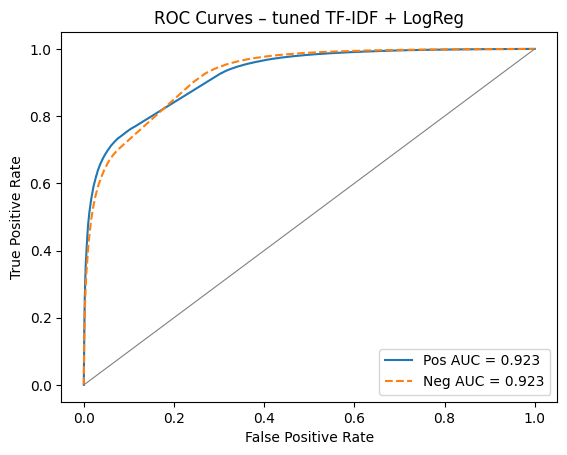

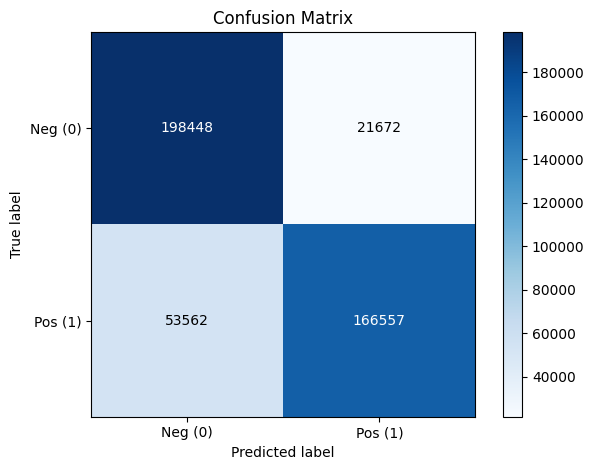

,precision,recall,f1-score,support
Negative (0),0.787,0.902,0.841,220120.000
Positive (1),0.885,0.757,0.816,220119.000
accuracy,0.829,0.829,0.829,0.829
macro avg,0.836,0.829,0.828,440239.000
weighted avg,0.836,0.829,0.828,440239.000


[CV] END logisticregression__C=0.17000372989211016, tfidfvectorizer__max_features=57194; total time= 6.5min
[CV] END logisticregression__C=0.1625667087686269, tfidfvectorizer__max_features=61090; total time= 6.3min
[CV] END logisticregression__C=0.10725209743171998, tfidfvectorizer__max_features=20769; total time= 6.1min
[CV] END logisticregression__C=0.20589728197687912, tfidfvectorizer__max_features=25311; total time= 6.2min
[CV] END logisticregression__C=2.9215732765498577, tfidfvectorizer__max_features=73707; total time= 7.2min
[CV] END logisticregression__C=0.8007296015034577, tfidfvectorizer__max_features=91932; total time= 7.2min
[CV] END logisticregression__C=0.389621702978914, tfidfvectorizer__max_features=38431; total time= 6.4min
[CV] END logisticregression__C=0.4717052037625178, tfidfvectorizer__max_features=55773; total time= 6.9min
[CV] END logisticregression__C=0.19721610970574002, tfidfvectorizer__max_features=76886; total time= 6.8min
[CV] END logisticregression__C=1.8

In [8]:
# Cell 7 — Evaluate the tuned model on the held-out validation set

# -------- assumes X_val and y_val still in memory -------------------------
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    recall_score, roc_auc_score, roc_curve,
    confusion_matrix, classification_report
)

# Reload the just-saved model (optional, but ensures we’re using the gzip copy)
import joblib, gzip
with gzip.open(f"{OUT_FILE}.gz", "rb") as f:
    tuned_model = joblib.load(f)

# Probabilities & per-class recall
probs  = tuned_model.predict_proba(X_val)
y_prob_pos = probs[:, 1]
y_prob_neg = probs[:, 0]

# AUC-ROC for each viewpoint
auc_pos = roc_auc_score(y_val, y_prob_pos)              # class 1 focus
auc_neg = roc_auc_score(1 - y_val, y_prob_neg)          # class 0 focus

# ROC curves
fpr_pos, tpr_pos, _ = roc_curve(y_val, y_prob_pos)
fpr_neg, tpr_neg, _ = roc_curve(1 - y_val, y_prob_neg)

# Predictions & confusion matrix (default 0.5 threshold)
y_pred = tuned_model.predict(X_val)
cm = confusion_matrix(y_val, y_pred, labels=[0, 1])

# Precision / recall / F1 table
report_df = (
    pd.DataFrame(
        classification_report(
            y_val,
            y_pred,
            labels=[0, 1],
            target_names=["Negative (0)", "Positive (1)"],
            digits=3,
            output_dict=True,
        )
    )
    .T
)

# ---- Plot ROC curves ------------------------------------------------------
plt.figure()
plt.plot(fpr_pos, tpr_pos, label=f"Pos AUC = {auc_pos:.3f}")
plt.plot(fpr_neg, tpr_neg, label=f"Neg AUC = {auc_neg:.3f}", linestyle="--")
plt.plot([0, 1], [0, 1], color="grey", linewidth=0.8)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves – tuned TF-IDF + LogReg")
plt.legend(loc="lower right")
plt.show()

# ---- Plot confusion matrix -----------------------------------------------
plt.figure()
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
ticks = np.arange(2)
plt.xticks(ticks, ["Neg (0)", "Pos (1)"])
plt.yticks(ticks, ["Neg (0)", "Pos (1)"])
th = cm.max() / 2
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="white" if cm[i, j] > th else "black")
plt.ylabel("True label"); plt.xlabel("Predicted label")
plt.tight_layout(); plt.show()

# ---- Show precision / recall / F1 ----------------------------------------
display(report_df.round(3))

## Threshold tuning ⇒ converts probabilities into labels that meet your negative-review capture goal.